#0 Check the environment

##0.1 GPU Info

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


##0.2 RAM Info

In [3]:
!grep MemTotal /proc/meminfo

MemTotal:       13290464 kB


#1 Preparing dataset

##1.1 Downloading the dataset

*   Flowers: [https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz](https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz)



In [4]:
!rm -f flower_photos.tgz
!wget -q https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
!tar zxf flower_photos.tgz
path_to_data = './flower_photos'

##1.2 Importing libraries

In [5]:
# Tensorflow for ML
import tensorflow as tf
import tensorflow.keras.utils as utils
import tensorflow.keras.applications as app
import tensorflow.keras.layers as layers
import tensorflow.keras as keras
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D as GAP, Dropout
from keras.models import load_model


# Callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Classification models
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7
from tensorflow.keras.applications import VGG16, ResNet50, ResNet50V2, InceptionV3, Xception, ResNet152, ResNet152V2, MobileNetV3Large, MobileNetV3Small

# Basic
import pandas as pd
import numpy as np
import os
import glob
# Vizualization Data
import matplotlib.pyplot as pltj.
import plotly.express as px

##1.3 Explore the dataset

##1.3.1 Get list of class names

In [6]:
class_names = list(filter(lambda x: os.path.isdir(os.path.join(path_to_data, x)), os.listdir(path_to_data)))
class_names = sorted(class_names)
num_classes = len(class_names)
print(f'Class names: \n {class_names}')
print(f'Total Number of Class names: {num_classes}')

Class names: 
 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Total Number of Class names: 5


##1.3.2 Vizualization the classes distribution

In [7]:
class_dis = [len(os.listdir(os.path.join(path_to_data, x))) for x in class_names]
lk_dis = dict(zip(class_names, class_dis))
print(f'Classes distribution: \n {lk_dis}')
fig = px.pie(names=class_names, values=class_dis, width=680)
fig.update_layout(title_text='Classes distribution')
fig.show()

Classes distribution: 
 {'daisy': 633, 'dandelion': 898, 'roses': 641, 'sunflowers': 699, 'tulips': 799}


##1.3.3 Show some pictures

Found 3670 files belonging to 5 classes.


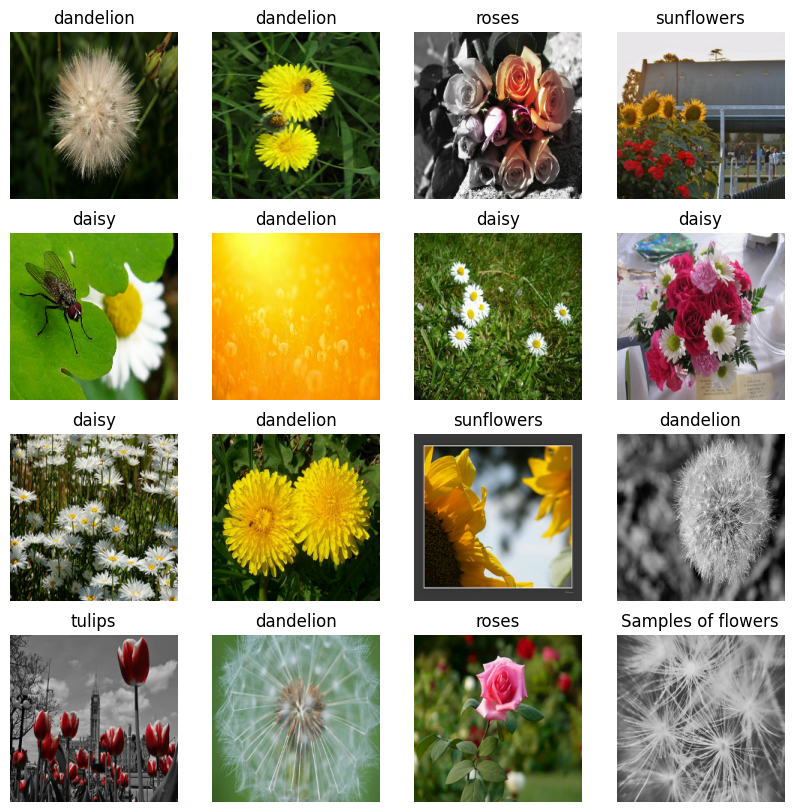

In [8]:
dataset = tf.keras.utils.image_dataset_from_directory(
    path_to_data,
    image_size=(224, 224),
    batch_size=16,
    shuffle=True
)
def show_images(dataset):
  plt.figure(figsize=(10, 10))
  for images, labels in dataset.take(1): # get random one batch from dataset(one batch ~ 16 images ~ random classes)
    for i in range(16):
      ax = plt.subplot(4, 4, i + 1)
      ax.imshow(images[i].numpy().astype("uint8"))
      ax.set_title(dataset.class_names[labels[i]])
      ax.axis("off")
  plt.title('Samples of flowers')
  plt.show()
show_images(dataset)

##1.4 Defining utilities and select a backbone

In [9]:
# Use pre-train model as backbone
# include_top = True to get all of layers in backbone
# include_top = False to get all of layers but freeze FC(Dense and Softmax) in backbone
feature_extractor = {
    "VGG16": VGG16(include_top=False, input_shape=(224,224,3), weights='imagenet'),
    "ResNet50": ResNet50(include_top=False, input_shape=(224,224,3), weights='imagenet'),
    "InceptionV3": InceptionV3(include_top=False, input_shape=(299,299,3), weights='imagenet'),
}
preprocess_methods = {
    "VGG16":app.vgg16.preprocess_input,
    "ResNet50":app.resnet50.preprocess_input,
    "InceptionV3":app.inception_v3.preprocess_input,
}
input_size = {
    "VGG16":(224,224),
    "ResNet50":(224,224),
    "InceptionV3":(299,299),
}

backbone = "ResNet50" #change this if needed
batch_size = 32

##1.5 Creating a training and testing set

In [10]:
# Use generator as train split test in scikit-learn in ML
generator = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    validation_split=0.2,
    preprocessing_function=preprocess_methods[backbone]
)

train_set = generator.flow_from_directory(
    path_to_data,
    target_size=input_size[backbone],
    class_mode='binary',      # as one hot encoder
    batch_size=batch_size,
    shuffle=True,
    subset='training'
)
valid_set = generator.flow_from_directory(
    path_to_data,
    target_size=input_size[backbone],
    class_mode='binary',      # as one hot encoder
    batch_size=batch_size,
    shuffle=True,
    subset='validation'
)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [11]:
train_set.class_indices

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

#2 Defining the model architecture

##2.1 Creating the model architecture

In [12]:
def create_model(backbone):
    # use backbone(pre-train) to extract features without FC and Softmax for classify
    # get features from backbone and
    # then move creating to new model for classification
    fextractor = feature_extractor[backbone]
    fextractor.trainable = False # freeze backbone(no training)
    model = keras.Sequential([
        fextractor,
        GAP(),  # fextractor[N,H,W,C] --GAP--> [N,C]
        Dense(num_classes, activation='softmax')
    ], name=backbone)
    return model

model = create_model(backbone)
model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23597957 (90.02 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


##2.2 Train and save the created model

In [13]:
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5,
    decay_rate=0.95,
    staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
cbs = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(backbone + '.h5', save_best_only=True),
]

# Train model
history = model.fit(
    train_set,
    validation_data=valid_set,
    epochs=15,
    callbacks=cbs,
    verbose=1
)


Epoch 1/15
11/92 [==>...........................] - ETA: 8:52 - loss: 22.0227 - accuracy: 0.4755

KeyboardInterrupt: 

In [ ]:
# list all data in history
print("Training History:")
print(history.history.keys())

# summarize history for accuracy
plt.figure(figsize=(8, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(8, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


##2.3 Load and evaluate the trained model

In [ ]:
model_file = './' + backbone + '.h5'
trained_model = load_model(model_file)
trained_model.evaluate(valid_set)

#3 Predicting and showing the result for some images

##3.1 Load test-set

In [ ]:
test_generator = ImageDataGenerator()
test_set = test_generator.flow_from_directory(
    path_to_data, # assume this is test-set
    target_size=input_size[backbone],
    class_mode='binary',      # as one hot encoder
    batch_size=batch_size,
    shuffle=False
)


##3.2 Predict images in a batch and show the results

In [ ]:
def show_prediction(dataset, model, backbone):
    for images, labels in dataset:
      print(images.dtype, images.min(), images.max())
      preprocess = preprocess_methods[backbone]
      batch = preprocess(images.copy())
      probs = model.predict(batch)
      preds_labels = probs.argmax(axis=-1)
      preds_labels = [class_names[idx] for idx in pred_labels]
      true_labels = [class_names[idx] for idx in labels]

      fig = plt.figure(figsize=(16, 16), layout='constrained')
      for i in range(16):
        ax = fig.add_subplot(4, 4, i +1)
        ax.imshow(images[i].astype('uint8'))
        ax.set_title("Predicted: "  + preds_labels[i] + ": " + true_labels[i])
        ax.axis('off')
      fig.suptitle('Predictions result for images in a batch')
      plt.show()
show_prediction(test_set, trained_model, backbone)